# Heart Disease Prediction - Modeling

Training Logistic Regression với K-Fold Cross Validation sử dụng PySpark.


======================================================================

======================================================================
##  1. Import Libraries & Initialize Spark
======================================================================
======================================================================

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Setup PySpark
if 'SPARK_HOME' in os.environ:
    del os.environ['SPARK_HOME']
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Initialize Spark
spark = SparkSession.builder.appName('HeartDiseaseModeling').getOrCreate()
print(' Đã tạo Spark Session thành công!')
spark

 Đã tạo Spark Session thành công!



======================================================================
## 2. Tải Dữ liệu Đã xử lý
======================================================================

In [2]:
# Tải dữ liệu đã xử lý từ notebook 01
print('\n' + '='*70)
print('ĐANG TẢI DỮ LIỆU')
print('='*70)

# Thử load từ file parquet (nếu đã lưu từ notebook 01)
data_path = '../data/processed/cardio_processed.parquet'

if os.path.exists(data_path):
    df = spark.read.parquet(data_path)
    print(f'\n Đã tải dữ liệu từ file: {data_path}')
    print(f'  • Số records: {df.count():,}')
    print(f'  • Số columns: {len(df.columns)}')
else:
    print(f'\n Không tìm thấy file: {data_path}')
    print('\nĐang tải và xử lý dữ liệu gốc...')

    # Load raw data
    df = spark.read.csv('../data/raw/cardio_train.csv', header=True, sep=',', inferSchema=True)
    pdf = df.toPandas()

    # Quick preprocessing
    print('  • Đang tính toán features...')
    pdf['age_years'] = pdf['age'] / 365
    pdf['bmi'] = pdf['weight'] / ((pdf['height'] / 100) ** 2)
    pdf['pulse_pressure'] = pdf['ap_hi'] - pdf['ap_lo']

    # Filter invalid data
    print('  • Đang lọc dữ liệu không hợp lý...')
    pdf_clean = pdf[
        (pdf['height'] >= 140) & (pdf['height'] <= 200) &
        (pdf['weight'] >= 40) & (pdf['weight'] <= 150) &
        (pdf['age_years'] >= 30) & (pdf['age_years'] <= 70) &
        (pdf['ap_hi'] > pdf['ap_lo']) &
        (pdf['ap_hi'] >= 80) & (pdf['ap_hi'] <= 200) &
        (pdf['ap_lo'] >= 60) & (pdf['ap_lo'] <= 140)
    ].copy()

    df = spark.createDataFrame(pdf_clean)

    # Feature engineering & scaling
    print('  • Đang chuẩn hóa dữ liệu...')
    feature_cols = ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                    'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'bmi', 'pulse_pressure']

    from pyspark.ml.feature import VectorAssembler
    assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
    df = assembler.transform(df)

    print('  • Đã assemble features (chưa scale - sẽ scale trong Pipeline)')


    print(f'\n Đã xử lý xong dữ liệu gốc')
    print(f'  • Số records: {df.count():,}')

# Hiển thị sample (chuyển sang pandas để đẹp hơn)
print('\n' + '='*70)
print('SAMPLE DỮ LIỆU (5 records đầu tiên)')
print('='*70)

# Lấy 5 records và chuyển sang pandas
sample_df = df.limit(5).toPandas()

# Hiển thị các columns quan trọng (không hiển thị vector dài)
display_cols = ['age_years', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
                'cholesterol', 'gluc', 'bmi', 'cardio']

if all(col in sample_df.columns for col in display_cols):
    print(sample_df[display_cols].to_string(index=False))
else:
    # Nếu không có các columns này, hiển thị tất cả trừ vectors
    cols_to_show = [c for c in sample_df.columns if c not in ['features', 'scaled_features', 'scaled_array']]
    print(sample_df[cols_to_show].to_string(index=False))

# Thông tin tổng quan
print('\n' + '='*70)
print('THÔNG TIN DỮ LIỆU')
print('='*70)
print(f'  • Tổng số records: {df.count():,}')
print(f'  • Số features: {len(df.select("scaled_features").first()[0])}')
print(f'  • Target variable: cardio (0/1)')

# Phân phối target
target_dist = df.groupBy('cardio').count().toPandas()
for _, row in target_dist.iterrows():
    pct = row['count'] / df.count() * 100
    label = 'Khỏe mạnh' if row['cardio'] == 0 else 'Bệnh tim'
    print(f'  • {label} (cardio={row["cardio"]}): {row["count"]:,} ({pct:.1f}%)')

print('='*70)



ĐANG TẢI DỮ LIỆU

 Đã tải dữ liệu từ file: ../data/processed/cardio_processed.parquet
  • Số records: 68,261
  • Số columns: 25

SAMPLE DỮ LIỆU (5 records đầu tiên)
 age_years  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc       bmi  cardio
 56.542466       1   170.0    80.0    170     80            1     1 27.681661       1
 61.934247       2   158.0    53.0    140    100            1     1 21.230572       1
 40.178082       1   164.0   107.5    140     90            1     1 39.968769       1
 56.238356       2   162.0    76.0    150     80            1     1 28.959000       1
 59.443836       1   165.0    70.0    130     90            3     3 25.711662       1

THÔNG TIN DỮ LIỆU
  • Tổng số records: 68,261
  • Số features: 17
  • Target variable: cardio (0/1)
  • Khỏe mạnh (cardio=0): 34,492 (50.5%)
  • Bệnh tim (cardio=1): 33,769 (49.5%)



======================================================================

======================================================================
## 3. Train/Test Split
======================================================================
======================================================================

In [3]:
# Drop scaled_features nếu có (từ lần chạy trước)
if 'scaled_features' in df.columns:
    df = df.drop('scaled_features')
    print('  • Đã xóa column scaled_features cũ')

# Split data
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

train_count = train_data.count()
test_count = test_data.count()
total = train_count + test_count

print(f' Dữ liệu Training: {train_count:,} ({train_count/total*100:.1f}%)')
print(f' Dữ liệu Test: {test_count:,} ({test_count/total*100:.1f}%)')

  • Đã xóa column scaled_features cũ
 Dữ liệu Training: 54,881 (80.4%)
 Dữ liệu Test: 13,380 (19.6%)


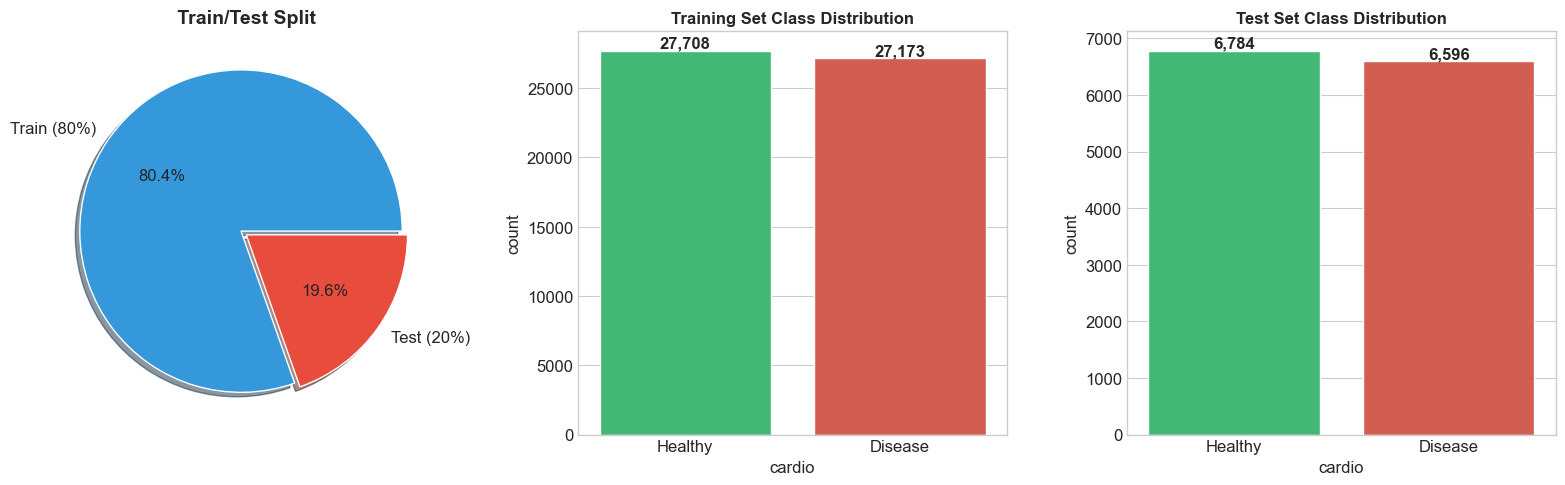

 Đã lưu biểu đồ vào ../results/01_train_test_split.png


In [4]:
# Visualize split
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Pie chart - Split ratio
axes[0].pie([train_count, test_count], labels=['Train (80%)', 'Test (20%)'],
            autopct='%1.1f%%', colors=['#3498db', '#e74c3c'], explode=(0.02, 0.02), shadow=True)
axes[0].set_title(' Train/Test Split', fontsize=14, fontweight='bold')

# Class distribution in train
train_pdf = train_data.select('cardio').toPandas()
test_pdf = test_data.select('cardio').toPandas()

sns.countplot(x='cardio', data=train_pdf, ax=axes[1], palette=['#2ecc71', '#e74c3c'])
axes[1].set_title('Training Set Class Distribution', fontsize=12, fontweight='bold')
axes[1].set_xticklabels(['Healthy', 'Disease'])
for i, v in enumerate(train_pdf['cardio'].value_counts().sort_index()):
    axes[1].text(i, v + 200, f'{v:,}', ha='center', fontweight='bold')

# Class distribution in test
sns.countplot(x='cardio', data=test_pdf, ax=axes[2], palette=['#2ecc71', '#e74c3c'])
axes[2].set_title('Test Set Class Distribution', fontsize=12, fontweight='bold')
axes[2].set_xticklabels(['Healthy', 'Disease'])
for i, v in enumerate(test_pdf['cardio'].value_counts().sort_index()):
    axes[2].text(i, v + 50, f'{v:,}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../results/01_train_test_split.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/01_train_test_split.png')


======================================================================

======================================================================
## 4. Logistic Regression with K-Fold Cross Validation
======================================================================
======================================================================

In [5]:
# Define Logistic Regression# Tạo Pipeline: VectorAssembler -> StandardScaler -> LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

# Stage 1: VectorAssembler (đã có từ trước)
# Stage 2: StandardScaler
scaler = StandardScaler(inputCol='features', outputCol='scaled_features',
                       withStd=True, withMean=True)

# Stage 3: LogisticRegression
lr = LogisticRegression(featuresCol='scaled_features', labelCol='cardio', maxIter=100)

# Tạo Pipeline
pipeline = Pipeline(stages=[scaler, lr])

print(' Pipeline stages:')
print('  1. StandardScaler (chuẩn hóa features)')
print('  2. LogisticRegression (classification)')

# Parameter Grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.001, 0.01, 0.1])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

print(f'\n Tổng số tổ hợp tham số: {len(paramGrid)}')
print('\n Tham số cần tune:')
print(' • regParam: [0.001, 0.01, 0.1]')
print(' • elasticNetParam: [0.0, 0.5, 1.0]')

 Pipeline stages:
  1. StandardScaler (chuẩn hóa features)
  2. LogisticRegression (classification)

 Tổng số tổ hợp tham số: 9

 Tham số cần tune:
 • regParam: [0.001, 0.01, 0.1]
 • elasticNetParam: [0.0, 0.5, 1.0]


In [6]:
# K-Fold Cross Validator (K=5)
evaluator = BinaryClassificationEvaluator(labelCol='cardio', metricName='areaUnderROC')

cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=5,
    parallelism=2
)

print(' Đang training với 5-Fold Cross Validation...')
print('⏳ Có thể mất vài phút...')


import time
start_time = time.time()

cvModel = cv.fit(train_data)
bestModel = cvModel.bestModel

end_time = time.time()
training_time = end_time - start_time

print('\n Hoàn tất training!')

# Lấy LogisticRegression model từ Pipeline (stage cuối cùng)
lr_model = bestModel.stages[-1]  # Stage cuối là LogisticRegression

print(f'\n Tham số Model tốt nhất:')
print(f' • regParam: {lr_model.getRegParam()}')
print(f' • elasticNetParam: {lr_model.getElasticNetParam()}')
print(f'\n Pipeline stages: {len(bestModel.stages)}')
print(f' 1. StandardScaler')
print(f' 2. LogisticRegression')


 Đang training với 5-Fold Cross Validation...
⏳ Có thể mất vài phút...

 Hoàn tất training!

 Tham số Model tốt nhất:
 • regParam: 0.01
 • elasticNetParam: 0.0

 Pipeline stages: 2
 1. StandardScaler
 2. LogisticRegression


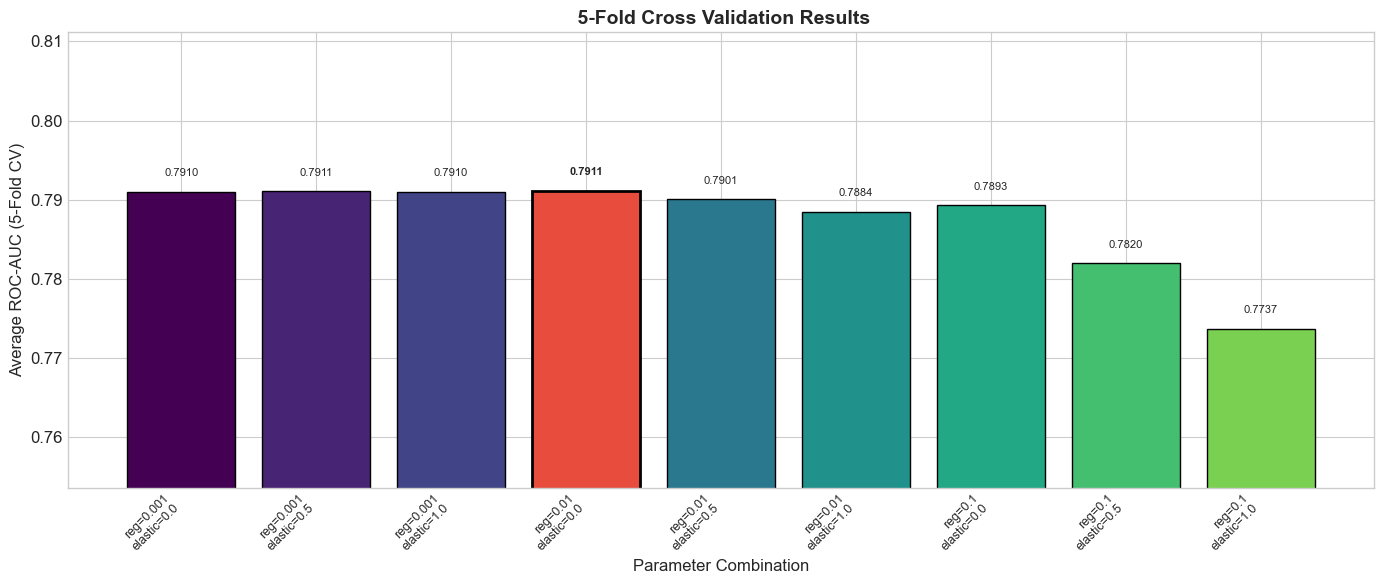

 Đã lưu biểu đồ vào ../results/02_cv_results.png


In [7]:
# Visualize Cross Validation Results
avg_metrics = cvModel.avgMetrics

# Create parameter labels
param_labels = []
for params in paramGrid:
    reg = params[lr.regParam]
    elastic = params[lr.elasticNetParam]
    param_labels.append(f'reg={reg}\nelastic={elastic}')

fig, ax = plt.subplots(figsize=(14, 6))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(avg_metrics)))
bars = ax.bar(range(len(avg_metrics)), avg_metrics, color=colors, edgecolor='black')
ax.set_xticks(range(len(param_labels)))
ax.set_xticklabels(param_labels, rotation=45, ha='right', fontsize=9)
ax.set_xlabel('Parameter Combination')
ax.set_ylabel('Average ROC-AUC (5-Fold CV)')
ax.set_title(' 5-Fold Cross Validation Results', fontsize=14, fontweight='bold')
ax.set_ylim([min(avg_metrics) - 0.02, max(avg_metrics) + 0.02])

# Highlight best
best_idx = avg_metrics.index(max(avg_metrics))
bars[best_idx].set_color('#e74c3c')
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(2)

for i, v in enumerate(avg_metrics):
    ax.text(i, v + 0.002, f'{v:.4f}', ha='center', fontsize=8, fontweight='bold' if i == best_idx else 'normal')

plt.tight_layout()
plt.savefig('../results/02_cv_results.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/02_cv_results.png')


======================================================================

======================================================================
## 5. Model Evaluation on Test Set
======================================================================
======================================================================

In [8]:
# Make predictions
predictions = bestModel.transform(test_data)

# Calculate metrics
accuracy = MulticlassClassificationEvaluator(labelCol='cardio', metricName='accuracy').evaluate(predictions)
precision = MulticlassClassificationEvaluator(labelCol='cardio', metricName='weightedPrecision').evaluate(predictions)
recall = MulticlassClassificationEvaluator(labelCol='cardio', metricName='weightedRecall').evaluate(predictions)
f1 = MulticlassClassificationEvaluator(labelCol='cardio', metricName='f1').evaluate(predictions)
roc_auc = BinaryClassificationEvaluator(labelCol='cardio', metricName='areaUnderROC').evaluate(predictions)
pr_auc = BinaryClassificationEvaluator(labelCol='cardio', metricName='areaUnderPR').evaluate(predictions)

print(' Metrics Đánh giá Model:')
print('=' * 40)
print(f' Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)')
print(f' Precision: {precision:.4f}')
print(f' Recall: {recall:.4f}')
print(f' F1-Score: {f1:.4f}')
print(f' ROC-AUC: {roc_auc:.4f}')
print(f' PR-AUC: {pr_auc:.4f}')

 Metrics Đánh giá Model:
 Accuracy: 0.7315 (73.15%)
 Precision: 0.7347
 Recall: 0.7315
 F1-Score: 0.7302
 ROC-AUC: 0.7985
 PR-AUC: 0.7762


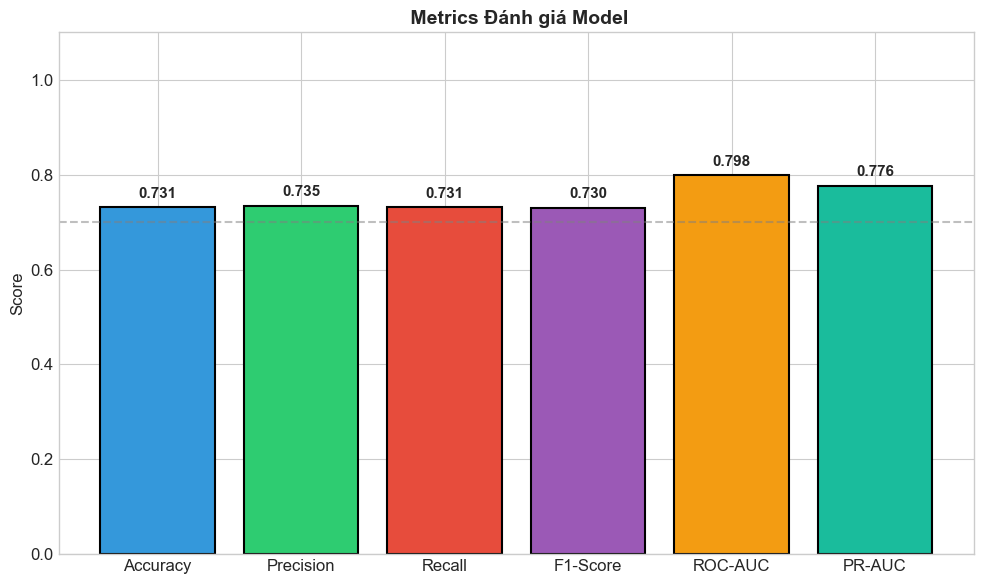

 Đã lưu biểu đồ vào ../results/03_evaluation_metrics.png


In [9]:
# Visualize metrics
fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
metrics_values = [accuracy, precision, recall, f1, roc_auc, pr_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

bars = ax.bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylim([0, 1.1])
ax.set_ylabel('Score')
ax.set_title(' Metrics Đánh giá Model', fontsize=14, fontweight='bold')
ax.axhline(y=0.7, color='gray', linestyle='--', alpha=0.5, label='Baseline (0.7)')

for bar, val in zip(bars, metrics_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f'{val:.3f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('../results/03_evaluation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/03_evaluation_metrics.png')


======================================================================

======================================================================
## 6. Confusion Matrix
======================================================================
======================================================================

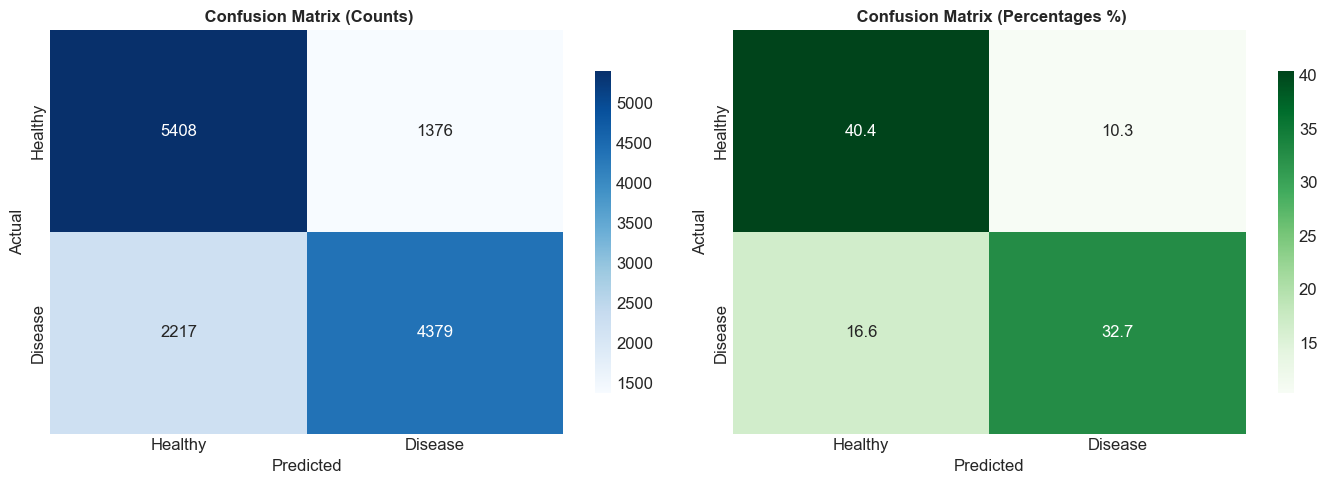

 Đã lưu biểu đồ vào ../results/04_confusion_matrix.png

 Metrics Chi tiết:
 True Negatives (TN): 5,408
 False Positives (FP): 1,376
 False Negatives (FN): 2,217
 True Positives (TP): 4,379


In [10]:
# Get predictions as pandas
pred_pdf = predictions.select('cardio', 'prediction').toPandas()
y_true = pred_pdf['cardio'].values
y_pred = pred_pdf['prediction'].values

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Heatmap - counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Healthy', 'Disease'], yticklabels=['Healthy', 'Disease'],
            cbar_kws={'shrink': 0.8})
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(' Confusion Matrix (Counts)', fontsize=12, fontweight='bold')

# Heatmap - percentages
cm_pct = cm.astype('float') / cm.sum() * 100
sns.heatmap(cm_pct, annot=True, fmt='.1f', cmap='Greens', ax=axes[1],
            xticklabels=['Healthy', 'Disease'], yticklabels=['Healthy', 'Disease'],
            cbar_kws={'shrink': 0.8})
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(' Confusion Matrix (Percentages %)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/04_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/04_confusion_matrix.png')

# Print detailed metrics
tn, fp, fn, tp = cm.ravel()
print(f'\n Metrics Chi tiết:')
print(f' True Negatives (TN): {tn:,}')
print(f' False Positives (FP): {fp:,}')
print(f' False Negatives (FN): {fn:,}')
print(f' True Positives (TP): {tp:,}')


======================================================================

======================================================================
## 7. ROC Curve
======================================================================
======================================================================

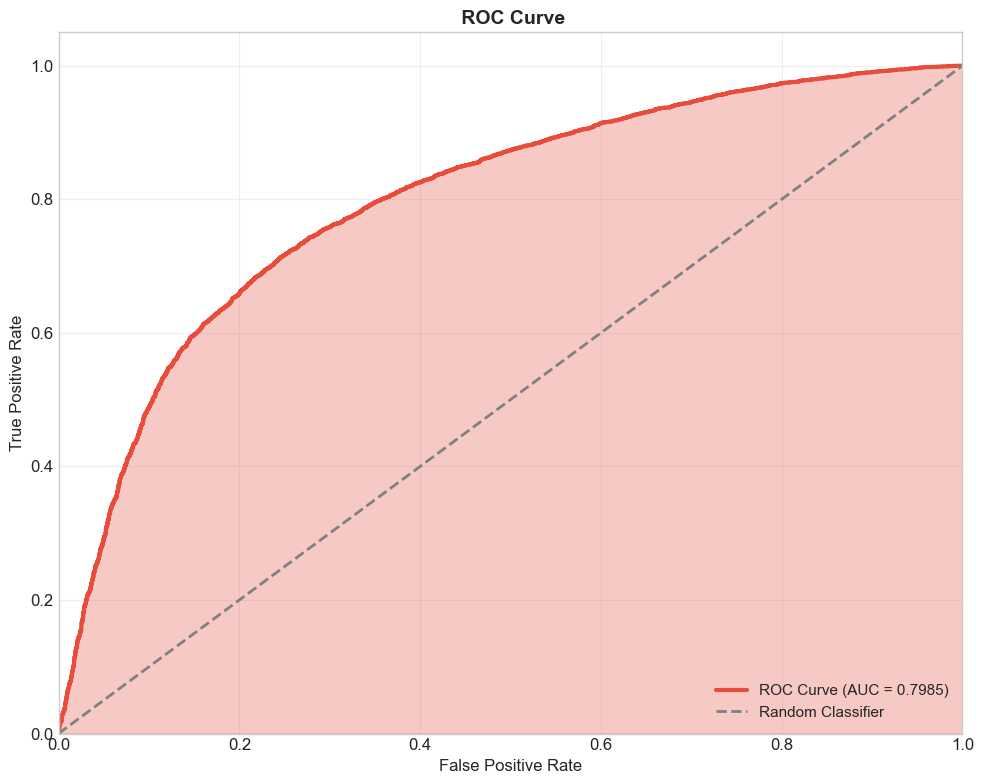

 Đã lưu biểu đồ vào ../results/05_roc_curve.png


In [11]:
# Get probability scores
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Extract probability of positive class
def extract_prob(v):
    return float(v[1])

extract_prob_udf = udf(extract_prob, FloatType())
pred_with_prob = predictions.withColumn('prob_positive', extract_prob_udf('probability'))
prob_pdf = pred_with_prob.select('cardio', 'prob_positive').toPandas()

y_true = prob_pdf['cardio'].values
y_scores = prob_pdf['prob_positive'].values

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc_score = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color='#e74c3c', lw=3, label=f'ROC Curve (AUC = {roc_auc_score:.4f})')
ax.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.3, color='#e74c3c')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title(' ROC Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/05_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/05_roc_curve.png')


======================================================================

======================================================================
## 8. Precision-Recall Curve
======================================================================
======================================================================

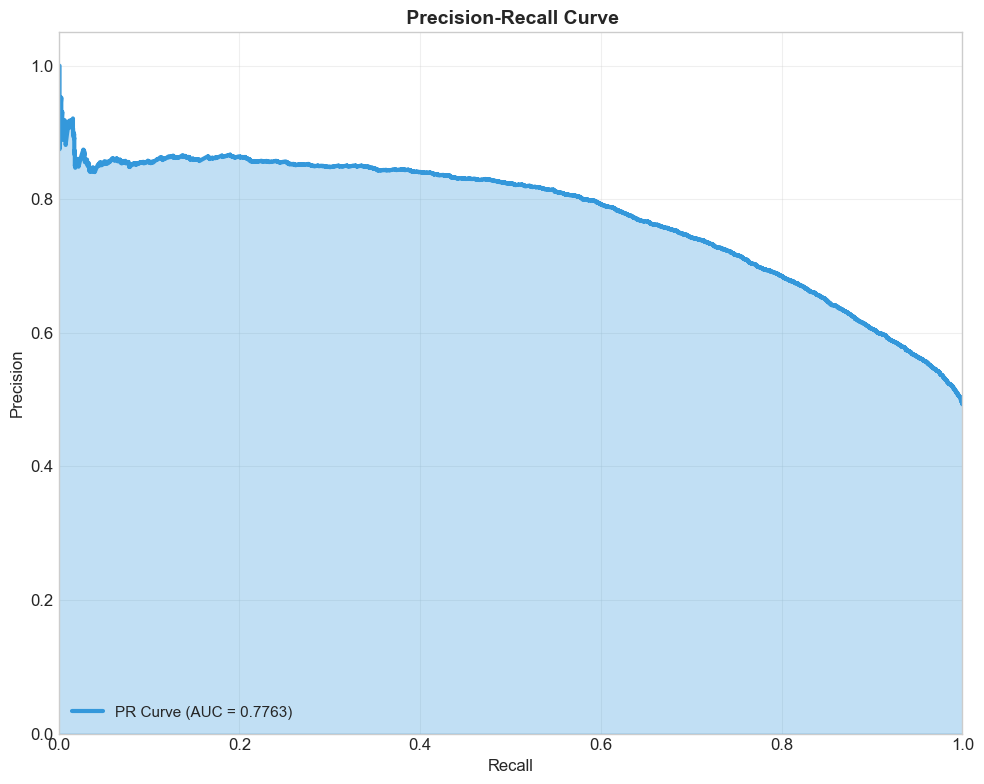

 Đã lưu biểu đồ vào ../results/06_pr_curve.png


In [12]:
# Calculate Precision-Recall curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_scores)
pr_auc_score = auc(recall_curve, precision_curve)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(recall_curve, precision_curve, color='#3498db', lw=3, label=f'PR Curve (AUC = {pr_auc_score:.4f})')
ax.fill_between(recall_curve, precision_curve, alpha=0.3, color='#3498db')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title(' Precision-Recall Curve', fontsize=14, fontweight='bold')
ax.legend(loc='lower left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/06_pr_curve.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/06_pr_curve.png')


======================================================================

======================================================================
## 9. Feature Importance
======================================================================
======================================================================

In [13]:
# Get feature coefficients từ LogisticRegression trong Pipeline
lr_model = bestModel.stages[-1]  # Stage cuối là LogisticRegression
coefficients = lr_model.coefficients.toArray()


# Load feature names
try:
    with open('../data/processed/feature_columns.txt', 'r') as f:
        feature_names = [line.strip() for line in f.readlines()]
except:
    feature_names = [f'Feature_{i}' for i in range(len(coefficients))]

# Create DataFrame
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=True)

print(' Hệ số Features:')
for _, row in feature_importance.iterrows():
    sign = '+' if row['Coefficient'] > 0 else '-'
    print(f" {sign} {row['Feature']}: {row['Coefficient']:.4f}")

AttributeError: 'PipelineModel' object has no attribute 'coefficients'

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 55124)
Traceback (most recent call last):
  File "C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\admin\AppData\Local\Programs\Python\Python311\Lib\socketserver.py", line 755, in __init__
    self.handle()
  File "D:\BTL Phân tích DLL\venv311\Lib\site-packages\pyspark\accumulators.py", line 299, in handle
    poll(accum_updates)
  File "D:\BTL Phân tích DLL\venv311\Lib\site-packages\pyspark\accumulators.py", line 271, i

In [ ]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

colors = ['#e74c3c' if c < 0 else '#2ecc71' for c in feature_importance['Coefficient']]
ax.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, edgecolor='black')
ax.set_xlabel('Coefficient Value')
ax.set_title(' Feature Importance (Logistic Regression Coefficients)', fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linewidth=0.8)

for i, (idx, row) in enumerate(feature_importance.iterrows()):
    ax.text(row['Coefficient'] + 0.01 if row['Coefficient'] >= 0 else row['Coefficient'] - 0.01,
            i, f"{row['Coefficient']:.3f}", va='center', ha='left' if row['Coefficient'] >= 0 else 'right', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Positive (↑ Risk)'),
                   Patch(facecolor='#e74c3c', label='Negative (↓ Risk)')]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../results/07_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/07_feature_importance.png')


======================================================================

======================================================================
## 10. K-Fold Performance Analysis
======================================================================
======================================================================

In [ ]:
# K-Fold scores analysis
cv_scores = cvModel.avgMetrics
best_cv_score = max(cv_scores)
mean_score = np.mean(cv_scores)
std_score = np.std(cv_scores)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
axes[0].boxplot(cv_scores, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#3498db', color='black'),
                medianprops=dict(color='red', linewidth=2))
axes[0].scatter([1], [best_cv_score], color='#e74c3c', s=100, zorder=5, label=f'Best: {best_cv_score:.4f}')
axes[0].set_ylabel('ROC-AUC Score')
axes[0].set_title(' Cross-Validation Scores Distribution', fontsize=12, fontweight='bold')
axes[0].set_xticklabels(['5-Fold CV'])
axes[0].legend()

# Line plot
axes[1].plot(range(1, len(cv_scores)+1), cv_scores, 'o-', color='#3498db', linewidth=2, markersize=8)
axes[1].axhline(y=mean_score, color='#2ecc71', linestyle='--', linewidth=2, label=f'Mean: {mean_score:.4f}')
axes[1].fill_between(range(1, len(cv_scores)+1), mean_score - std_score, mean_score + std_score, alpha=0.2, color='#2ecc71')
axes[1].set_xlabel('Parameter Combination')
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_title(' CV Scores by Parameter Combination', fontsize=12, fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/08_kfold_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print(' Đã lưu biểu đồ vào ../results/08_kfold_analysis.png')
print(f'\n Thống kê CV: Mean={mean_score:.4f}, Std={std_score:.4f}')


======================================================================

======================================================================
## 11. Save Model & Results
======================================================================
======================================================================

In [ ]:
# Save the best Pipeline (bao gồm StandardScaler + LogisticRegression)
pipeline_path = '../model/heart_disease_pipeline'
bestModel.write().overwrite().save(pipeline_path)
print(f' Đã lưu Pipeline vào {pipeline_path}')
print(' Pipeline bao gồm:')
print('  • StandardScaler (chuẩn hóa)')
print('  • LogisticRegression (dự đoán)')

In [ ]:
# Save model weights
with open('../model/model_weights.txt', 'w') as f:
    f.write('=' * 50 + '\n')
    f.write('LOGISTIC REGRESSION MODEL WEIGHTS\n')
    f.write('=' * 50 + '\n\n')
    f.write(f'Intercept: {bestModel.intercept}\n\n')
    f.write('Coefficients:\n')
    for i, (feat, coef) in enumerate(zip(feature_names, coefficients)):
        f.write(f'  {feat}: {coef:.6f}\n')
    f.write('\n' + '=' * 50 + '\n')
    f.write('HYPERPARAMETERS\n')
    f.write('=' * 50 + '\n\n')
    f.write(f'regParam: {bestModel.getRegParam()}\n')
    f.write(f'elasticNetParam: {bestModel.getElasticNetParam()}\n')

print(' Đã lưu trọng số model vào ../model/model_weights.txt')

In [ ]:
# Lưu model dưới dạng Pickle (để deploy)
import pickle

print('\n Đang lưu model cho deployment...')

# 1. Lưu model coefficients và intercept
model_data = {
    'coefficients': bestModel.coefficients.toArray().tolist(),
    'intercept': float(bestModel.intercept),
    'regParam': bestModel.getRegParam(),
    'elasticNetParam': bestModel.getElasticNetParam(),
    'maxIter': bestModel.getMaxIter(),
    'feature_names': feature_names,
    'num_features': len(feature_names)
}

# 2. Lưu dưới dạng Pickle
with open('../model/logistic_regression.pkl', 'wb') as f:
    pickle.dump(model_data, f)
print(' Đã lưu: ../model/logistic_regression.pkl')

# 3. Lưu dưới dạng JSON (dễ đọc)
import json
with open('../model/model_weights.json', 'w') as f:
    json.dump(model_data, f, indent=2)
print(' Đã lưu: ../model/model_weights.json')

# 4. Lưu feature names
with open('../model/feature_names.json', 'w') as f:
    json.dump({'features': feature_names}, f, indent=2)
print(' Đã lưu: ../model/feature_names.json')

# 5. Lưu metrics
metrics_data = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc),
    'training_time': training_time if 'training_time' in locals() else None
}

with open('../model/metrics.json', 'w') as f:
    json.dump(metrics_data, f, indent=2)
print(' Đã lưu: ../model/metrics.json')

print('\n' + '='*70)
print(' ĐÃ LƯU TẤT CẢ FILES CHO DEPLOYMENT!')
print('='*70)
print('\nFiles đã lưu:')
print(' Model:')
print(' • ../model/logistic_regression_model/ (PySpark)')
print(' • ../model/logistic_regression.pkl (Pickle)')
print(' Weights:')
print(' • ../model/model_weights.json (JSON)')
print(' • ../model/model_weights.txt (Text)')
print(' Metadata:')
print(' • ../model/feature_names.json')
print(' • ../model/metrics.json')
print(' Visualizations:')
print(' • ../results/01_train_test_split.png')
print(' • ../results/02_cv_results.png')
print(' • ../results/03_evaluation_metrics.png')
print(' • ../results/04_confusion_matrix.png')
print(' • ../results/05_roc_curve.png')
print(' • ../results/06_pr_curve.png')
print(' • ../results/07_feature_importance.png')
print(' • ../results/08_kfold_analysis.png')


In [ ]:
# Save evaluation metrics
metrics_dict = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC-AUC': roc_auc,
    'PR-AUC': pr_auc
}

with open('../results/model_metrics.txt', 'w') as f:
    f.write('=' * 40 + '\n')
    f.write('MODEL EVALUATION METRICS\n')
    f.write('=' * 40 + '\n\n')
    for metric, value in metrics_dict.items():
        f.write(f'{metric}: {value:.4f}\n')
    f.write('\n' + '=' * 40 + '\n')
    f.write('CONFUSION MATRIX\n')
    f.write('=' * 40 + '\n\n')
    f.write(f'True Negatives (TN):  {tn:,}\n')
    f.write(f'False Positives (FP): {fp:,}\n')
    f.write(f'False Negatives (FN): {fn:,}\n')
    f.write(f'True Positives (TP):  {tp:,}\n')

print(' Metrics saved to ../results/model_metrics.txt')


======================================================================

======================================================================
## 12. Final Summary
======================================================================
======================================================================

In [ ]:
print('=' * 60)
print(' MODELING COMPLETED SUCCESSFULLY!')
print('=' * 60)
print(f'\n Model Performance:')
print(f' • Accuracy: {accuracy*100:.2f}%')
print(f' • ROC-AUC: {roc_auc:.4f}')
print(f' • F1-Score: {f1:.4f}')
print(f'\n Best Hyperparameters:')
print(f' • regParam: {bestModel.getRegParam()}')
print(f' • elasticNetParam: {bestModel.getElasticNetParam()}')
print(f'\n Saved Files:')
print(f' • model/logistic_regression_model/')
print(f' • model/model_weights.txt')
print(f' • results/model_metrics.txt')
print(f' • results/*.png (8 visualization charts)')
print('\n Ready for deployment!')

In [ ]:
# Stop Spark
print(' Run spark.stop() when done to release resources')